In [66]:
import sqlite3
import sys
sys.path.append("..")
import json
from Visualization.bookmakers import get_bookmakers_coef
con = sqlite3.connect('../data/on_court.db')
cursor = con.cursor()
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from math import sqrt
from trueskill import BETA
from trueskill.backends import cdf
import progressbar
import numpy as np
import pandas as pd
from trueskill import Rating, rate_1vs1

def win_probability(player_rating, opponent_rating):
    delta_mu = player_rating.mu - opponent_rating.mu
    denom = sqrt(2 * (BETA * BETA) + pow(player_rating.sigma, 2) + pow(opponent_rating.sigma, 2))
    return cdf(delta_mu / denom)

In [67]:
odds = pd.read_csv('../data/odds_atp.csv')
games = pd.read_csv('../data/games_atp.csv')
games_with_odds = pd.merge(odds, games, how='inner', 
                           left_on=['ID1_O', 'ID2_O', 'ID_T_O', 'ID_R_O'], 
                           right_on=['ID1_G', 'ID2_G', 'ID_T_G', 'ID_R_G'])
games = games.as_matrix()
max_id = max(games[:, 0].max(), games[:, 1].max()) + 1
ratings = [Rating() for i in range(max_id)]

In [69]:
data_ar_to_csv = []
for ii, i in enumerate(ratings):
    data_ar_to_csv.append([ii, i.mu, i.sigma])
npar_data = np.array(data_ar_to_csv)
csv_to_save = pd.DataFrame(data = npar_data, columns=['ID', 'mu', 'sigma'])
csv_to_save.to_csv('octorate.csv')

In [57]:
bar = progressbar.ProgressBar(max_value=len(games))
for ii, i in enumerate(games[:int(len(games) * 0.9)]):
    bar.update(ii)
    ratings[i[0]], ratings[i[1]] = rate_1vs1(ratings[i[0]], ratings[i[1]])

 89% (608546 of 676393) |###################################    | Elapsed Time: 0:04:53 ETA: 0:00:32

In [70]:
games_with_odds_test = games_with_odds.tail(10000)

In [71]:
id1 = np.array(games_with_odds_test['ID1_G'])
id2 = np.array(games_with_odds_test['ID2_G'])
k1 = np.array(games_with_odds_test['K1'])
k2 = np.array(games_with_odds_test['K2'])

In [72]:
bookmaker_prob = 1 - k1 / (k1 + k2)

In [73]:
octoprob = []
for i1, i2 in zip(id1, id2):
    octoprob.append(win_probability(ratings[i1], ratings[i2]))

In [74]:
cnt = 0
cnt_bet = 0
bablo = 1
i = 0
bbbl = []
for o, b in zip(octoprob, bookmaker_prob):
    o_c = 1 if o > 0.5 else 0.
    b_c = 1 if b > 0.5 else 0.
    if (o_c and k1[i] > 2.9 or not o_c and k2[i] > 2.9) \
    and ((k1[i] > k2[i] and o > 0.45) or (k1[i] < k2[i] and o < 0.55)):
        cnt_bet += 1
        if k1[i] > k2[i]:
            cnt += 1
            bablo += k1[i] - 1
        else:
            bablo -=1
    bbbl.append(bablo)
    i += 1
print (bablo, bablo / cnt)

143.16500046 1.70434524357


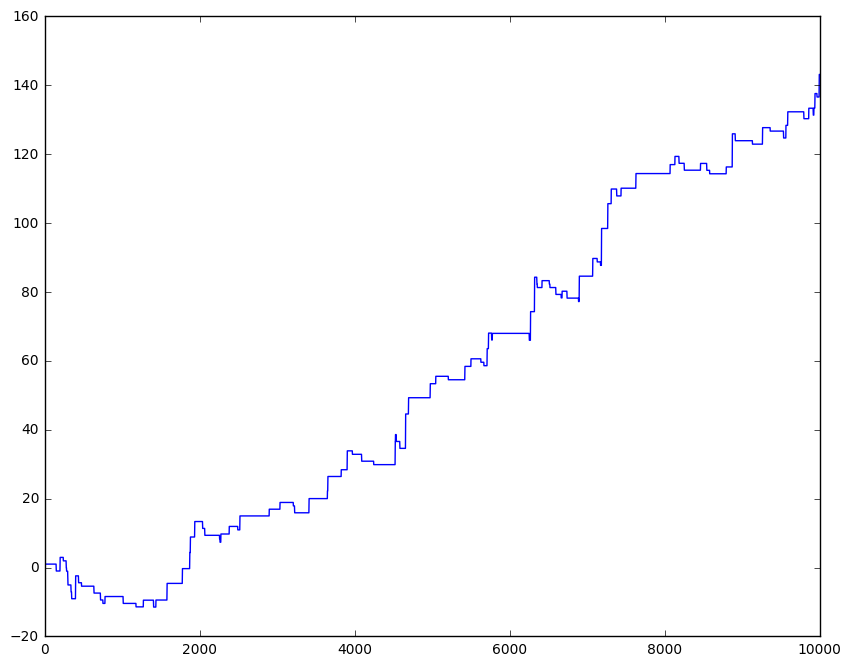

In [75]:
bbbl = np.array(bbbl)
plt.figure(figsize=(10, 8))
plt.plot(range(len(bbbl)),bbbl)

In [93]:
octorate = pd.read_csv('octorate.csv')

In [94]:
import sys
sys.path.append("..")
from Model.octorate import win_probability_by_rate
def win_prob_from_csv(octorate, pid1, pid2):
    p1 = octorate[octorate['ID']==pid1].as_matrix()[0]
    p2 = octorate[octorate['ID']==pid2].as_matrix()[0]
    return win_probability_by_rate(Rating(mu=p1[1], sigma=p1[2]), Rating(mu=p2[1], sigma=p2[2]))


In [96]:
win_prob_from_csv(octorate, 27, 9)

0.66883328915873075